## Learning to rank with LambdaMART

In this notebook we apply the LambdaMART, a pairwise learning to rank method, to a text search data set. We use the XGBoost implementation of LambdaMART. 

In [57]:
import numpy as np
import pickle
import xgboost as xgb
import graphviz
import matplotlib
import math


## Data

The data I use is the TCD_All_Micro dataset.

The data is a LETOR-formatted, of the form: "reference lable (ie ranking given by human), query id, query-url pairs (length 6 feature vectors)".  

The data has been pre-processed by a bash script which stores grouping information from the query ids in a .txt.group file, and removes the query id from the raw datasets.  

In [58]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mslrweb10k/vali1_dat.txt.group
/kaggle/input/mslrweb10k/test_dat.txt.group
/kaggle/input/mslrweb10k/train_dat.txt
/kaggle/input/mslrweb10k/qids.txt
/kaggle/input/mslrweb10k/vali_dat.txt
/kaggle/input/mslrweb10k/train1_dat.txt.group
/kaggle/input/mslrweb10k/test_qids.txt
/kaggle/input/mslrweb10k/train_dat.txt.group
/kaggle/input/mslrweb10k/vali.txt
/kaggle/input/mslrweb10k/vali_qids.txt
/kaggle/input/mslrweb10k/test.txt
/kaggle/input/mslrweb10k/test_dat.txt
/kaggle/input/mslrweb10k/train.txt
/kaggle/input/mslrweb10k/vali_dat.txt.group
/kaggle/input/mslrweb10k/process_data.sh
/kaggle/input/mslrweb10k/test1_dat.txt.group
/kaggle/input/tcdletorformat/vali1_dat.txt.group
/kaggle/input/tcdletorformat/test_dat.txt.group
/kaggle/input/tcdletorformat/train_dat.txt
/kaggle/input/tcdletorformat/qids.txt
/kaggle/input/tcdletorformat/vali_dat.txt
/kaggle/input/tcdletorformat/train1_dat.txt.group
/kaggle/input/tcdletorformat/test_qids.txt
/kaggle/input/tcdletorformat/train_dat.txt.grou

In [59]:
#training_data = xgb.DMatrix('../input/mslrweb10k/train_dat.txt')#
#testing_data = xgb.DMatrix('../input/mslrweb10k/test_dat.txt')
training_data = xgb.DMatrix('../input/tcdletorformat/train_dat.txt')
testing_data = xgb.DMatrix('../input/tcdletorformat/test_dat.txt')




[08:39:01] 349x7 matrix with 2094 entries loaded from ../input/tcdletorformat/train_dat.txt
[08:39:01] 2 groups are loaded from ../input/tcdletorformat/train_dat.txt.group
[08:39:01] 511x7 matrix with 3066 entries loaded from ../input/tcdletorformat/test_dat.txt
[08:39:01] 3 groups are loaded from ../input/tcdletorformat/test_dat.txt.group


In [60]:
#testing_data.print.xgb.DMatrix

In [61]:
import pandas as pd
testing_data_file = '../input/tcdletorformat/test_dat.txt'
testing_data_set = pd.read_csv(testing_data_file, header = None)

In [62]:
testing_data_set.head(5)

,0
0,5 1:4.1230125 2:0.64495915 3:0.0 4:0.0 5:512.0...
1,4 1:3.8054292 2:0.5946939 3:0.0 4:0.0 5:388.0 ...
2,5 1:4.1098194 2:0.3000001 3:0.0 4:0.0 5:314.0 ...
3,5 1:4.263464 2:0.3193567 3:0.0 4:1.0 5:170.0 6...
4,5 1:3.3916144 2:0.3000001 3:0.0 4:0.0 5:296.0 ...


## Building a Model

We now set the model parameters:

'max_depth' = number of layers in the tree
'eta' = step shrinkage size, used to prevent overfitting
'silent' = if 1, doesn't print updates. 
'objective' = which method is used/which objective function is minimised. 'rank:pairwise' implements LambdaMART.
'num_round' = number of boosting rounds. 

* rank:pairwise: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized 
* rank:ndcg: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized

In [63]:
param = {'max_depth':10, 'eta':0.3, 'objective':'rank:pairwise', 'num_round':15}
#param = {'max_depth':5, 'eta':0.3, 'objective':'rank:ndcg', 'num_round':15}

#param2 = {'max_depth':3, 'eta':0.3, 'objective':'rank:pairwise', 'num_round':15}

In [64]:
model = xgb.train(param, training_data)
#model2 = xgb.train(param2, training_data)


[08:39:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Visualising the model

The model takes the form of a decision tree, where splits at nodes are conditional on the inputted features in the feature vector for each query.  

In [65]:
%matplotlib inline

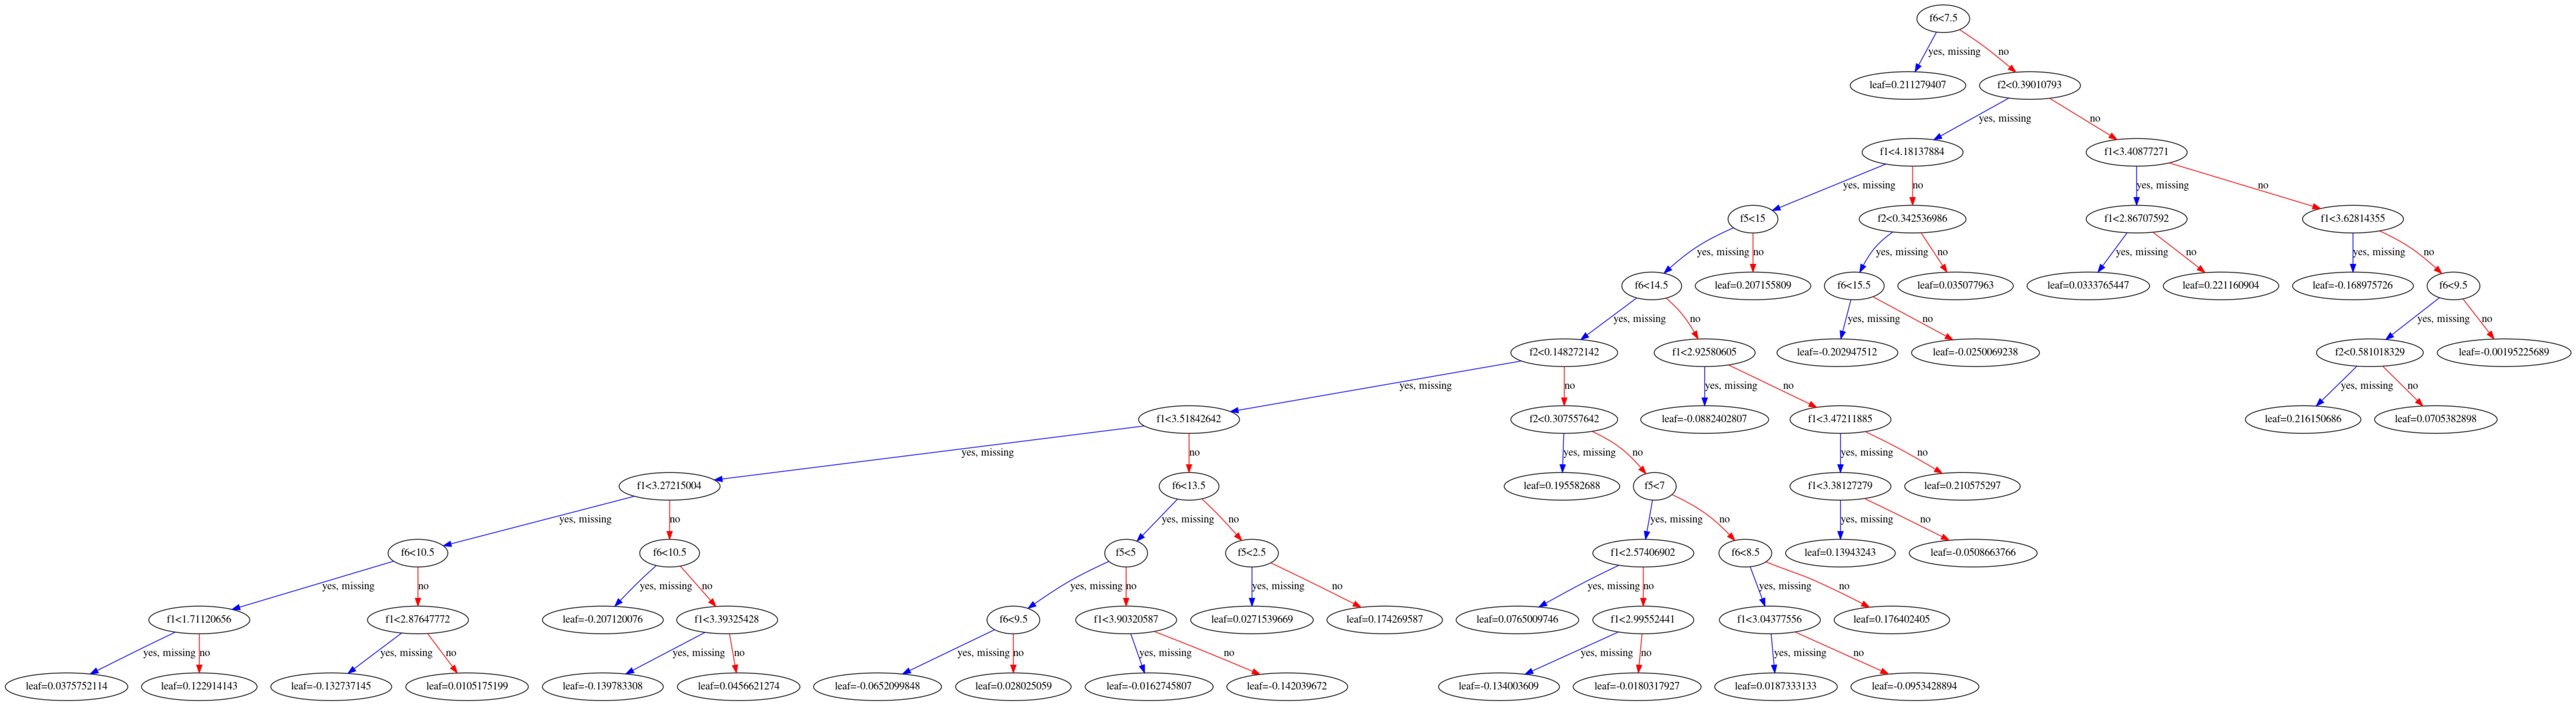

In [66]:
xgb.plot_tree(model, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)

In [67]:
#xgb.plot_tree(model2, num_trees=3)
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(150, 100)

It is possible to look a the importance of each of the 6 features within the model. In the feature plot below we see that the most 'important' feature in determining the output of the model for a given input is feature 1 (BM25)


* feature 1: BM25  (like tf-idf, but with a probablistic twist)
* feature 2: documentRecency (last modification date)
* feature 3: isContact  (url contains the word 'contact')
* feature 4: isAbout    (url contains keyword 'about')
* feature 5: rawHits    (a measure of document popularity)
* feature 6: urlLength  (number of terms in url path hierarchy)

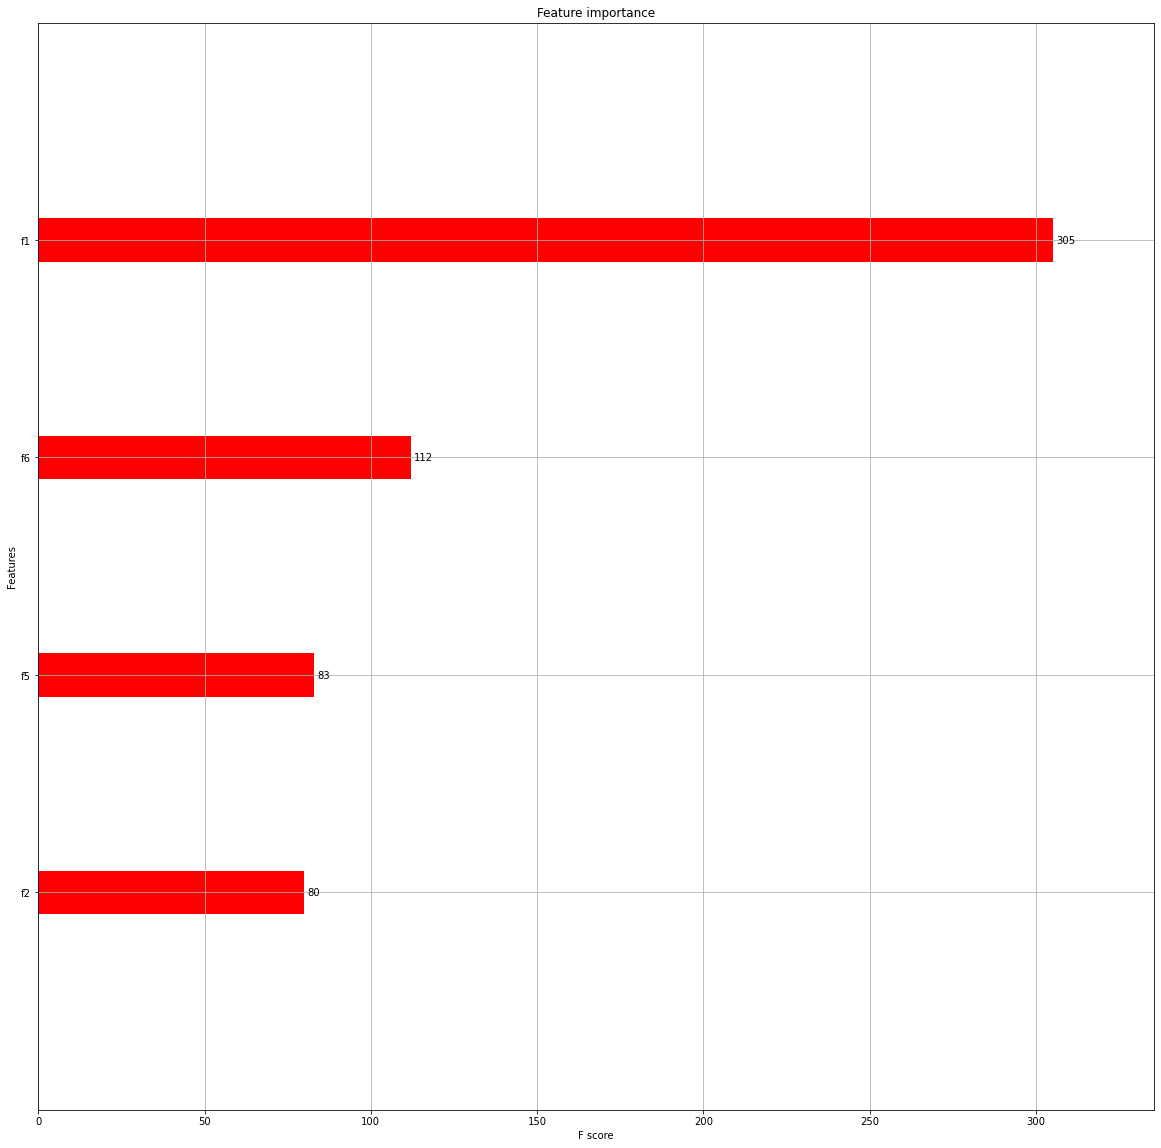

In [68]:
ax = xgb.plot_importance(model, color='red')
fig = ax.figure
fig.set_size_inches(20, 20)

In [69]:
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
#ax = xgb.plot_importance(model, color='blue')
#plot_importance(model)
#pyplot.show()
#fig = ax.figure
#fig.set_size_inches(40, 40)

In [70]:
#print(model.booster().feature_importances_)
#model.booster().get_score(importance_type='weight')
#from xgboost import XGBClassifier
#pyplot.bar(range(len(model.feature_importances_)), ax.feature_importances_)
#pyplot.show()

## Making predictions

'preds' contains predicted relelvance values for all of the queries in the testing data set. We want to compute the normalised discounted cumulative gain, or ndgc, of the results, in order to quantify the goodness of the model. This will allow us to compare models and tuning parameters. 

Predictions are made by passing a feature vector from the testing data set through the decision tree, ending at a leaf which gives a numerical value. The numerical value represents the relavance of that document for that query. 

In [71]:
preds = model.predict(testing_data)
#preds2 = model2.predict(testing_data)

In [72]:
preds

array([ 2.5745301 ,  2.5745301 ,  2.473059  ,  2.473059  ,  2.5533266 ,
        2.473059  ,  2.5745301 ,  2.5745301 ,  2.5745301 ,  2.3414536 ,
        2.1895337 ,  0.13215977,  1.8865305 ,  0.7728587 ,  0.47228122,
       -0.19436747, -0.29583967,  0.1275149 ,  0.5626317 , -0.03324574,
        0.66235375,  0.7497448 ,  0.17715272,  1.5505071 ,  0.28715277,
        1.0416747 ,  0.43016645,  1.8429734 ,  0.6868924 ,  0.2878679 ,
        2.2759266 ,  1.8799921 ,  0.7959381 ,  0.8735186 ,  2.3414536 ,
        2.5533266 ,  0.7497448 ,  1.5125647 ,  1.8485178 ,  0.3026328 ,
        0.27677643,  1.2758791 ,  1.5125647 ,  1.8865305 ,  0.8570436 ,
        1.4192603 ,  1.8865305 ,  0.6520436 ,  0.58371   ,  0.21886057,
        1.8057059 ,  0.85067403,  0.45766163,  0.7497448 ,  1.4192603 ,
        0.51781684, -0.5542489 ,  0.51781684,  0.43245846,  0.8700774 ,
        0.15392604, -0.61235297,  0.8700774 ,  0.37916616, -0.1418333 ,
        1.0537246 ,  2.3414536 ,  0.59906906,  0.5599619 ,  0.68

In [73]:
#preds2

### Normal Distributed Cumulative Gain 
ndcg is a metric commonly used to rate the output of learning to rank models.
ndcg is a measure of the relative goodness of the output of the ranking algorithm, and takes value between 0 and 1, with a 1 denoting that the algorithm has optimally ordered the pages for a query, and a 0 denoting that the pages have been reverse ordered. 

In [74]:
""" this returns 0 if all of the ordered data is undesirable"""
def ndcg_p(ordered_data, p):
    """normalised discounted cumulative gain"""
    if sum(ordered_data)==0:
        return 0
    else:
        indexloop = range(0, p)
        DCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*(math.log((float(index)+2), 2)**(-1))
            DCG_p = DCG_p + current_ratio
        ordered_data.sort(reverse=True)  
        K = len(ordered_data)
        indexloop = range(0, K)
        iDCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*((math.log((index+2), 2))**(-1))
            iDCG_p = iDCG_p + current_ratio
        return(DCG_p/iDCG_p)

In [75]:
f = open('../input/tcdletorformat/test_dat.txt.group', 'r')
x = f.readlines()
groups =[]
for line in x:
    groups.append(int(line))
f.close()

In [76]:
testing_labels = testing_data.get_label()

In [77]:
## compute ndgc for each query.
nquerys=range(0,len(groups))
lower=0
upper=0
ndcgs=[]
for i in nquerys:
        many=groups[i]
        upper = upper+many
        predicted = preds[lower:upper]
        labled = testing_labels[lower:upper]
        ordered = [x for _,x in sorted(zip(predicted,labled), reverse=True)]
        result = ndcg_p(ordered, many)
        ndcgs.append(result)
        lower=upper


In [78]:
ndcgs

[0.9351477341479782, 0.9334916239407313, 0.9516627192709535]

For each query we see a number between 0 and 1 denoting how well the pages for that query were ordered. 

In [79]:
# evaluate using the nDCG metric
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [80]:

print(ndcg_at_k(preds,1, method=1)) 
print(ndcg_at_k(preds,3, method=1))
print(ndcg_at_k(preds,5, method=1))
print(ndcg_at_k(preds,10, method=1))
print(ndcg_at_k(preds,20, method=1))
print(ndcg_at_k(preds,100, method=1))
print(ndcg_at_k(preds,200, method=1))

1.0
0.990752046695878
0.9864786076455656
0.9823758954277827
0.7218176187453365
0.5533519984116789
0.5712686169025121


In [81]:
def vif_scores(testing_data_set):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = testing_data_set.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(testing_data_set.values,i) for i in range(testing_data_set.shape[1])]
    return VIF_Scores
df1 = testing_data_set.iloc[:,:-1]
vif_scores(df1)

,Independent Features,VIF Scores
